# Stochastic Gradient Descent (SGD)

## Load Dataset from sklearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


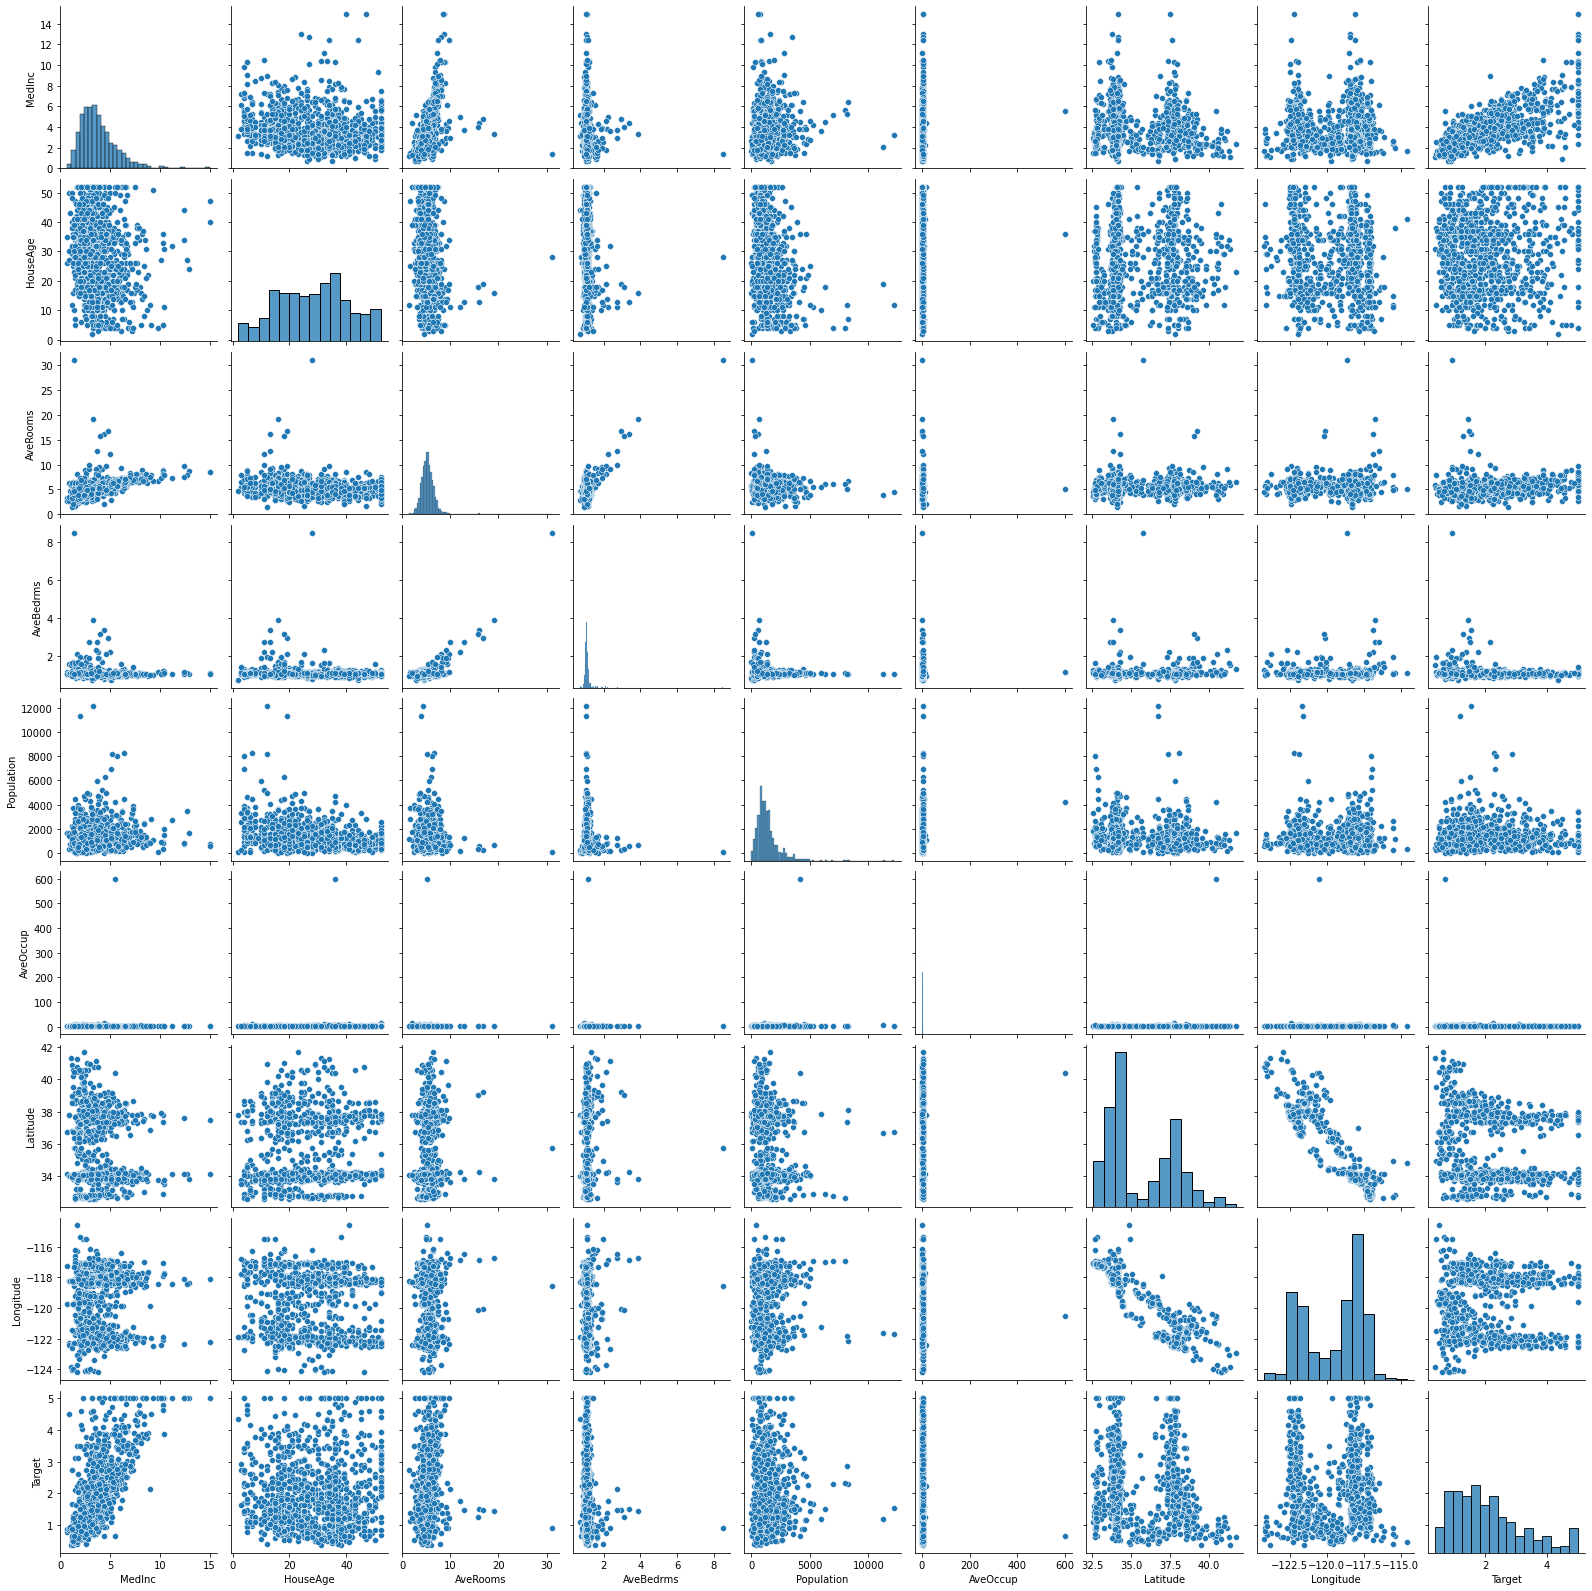

In [4]:
sns.pairplot(df.sample(1000))
plt.show()

## Preprocessing
standarscaler

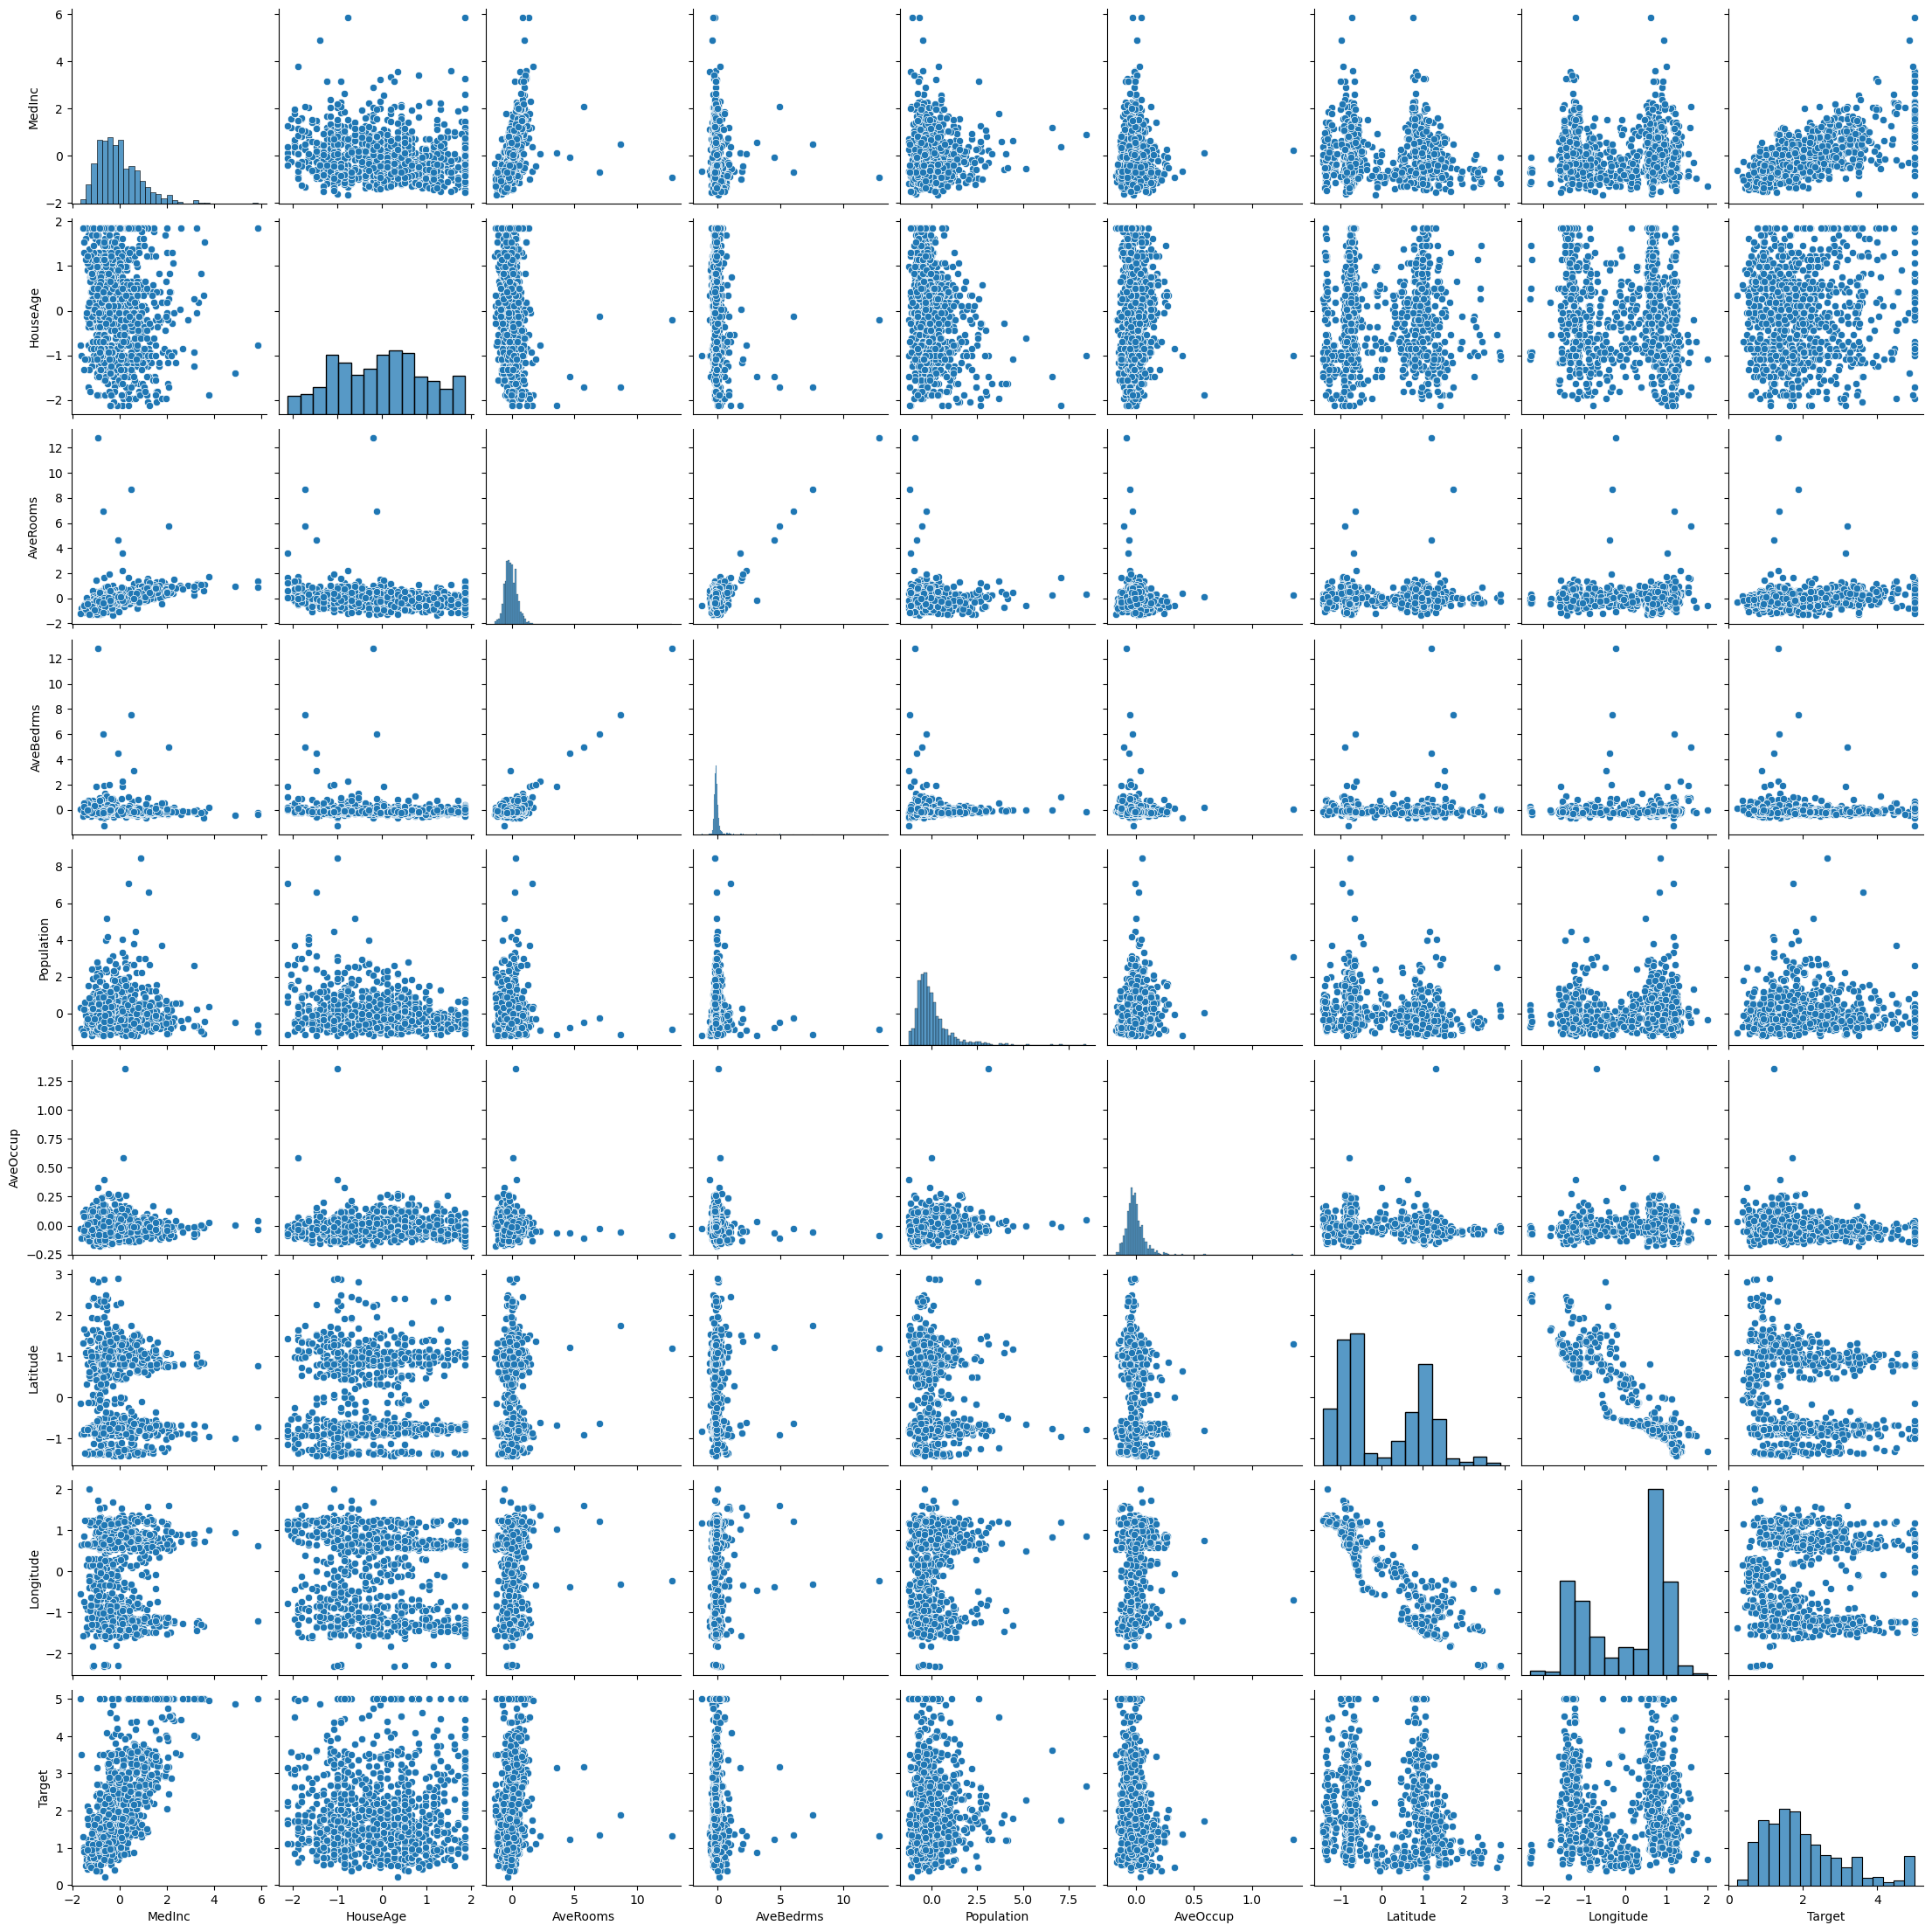

In [5]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

sns.pairplot(df.sample(1000))
plt.show()

## Train Model with PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [8]:
X = data[:, :-1]
y = data[:, -1:]

print(X.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [9]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

## Build Models

In [10]:
model = nn.Sequential(
    nn.Linear(X.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [12]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices = torch.randperm(X.size(0))
    x_ = torch.index_select(X, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
        total_loss += float(loss) # This is very important to prevent memory leak.
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, total_loss))
    
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)
# |y_hat| = (total_size, output_dim)
# |y| = (total_size, output_dim)

Epoch 200: loss=3.3087e-01
Epoch 400: loss=3.2011e-01
Epoch 600: loss=3.1266e-01
Epoch 800: loss=3.0961e-01
Epoch 1000: loss=3.0631e-01
Epoch 1200: loss=3.0441e-01
Epoch 1400: loss=3.0384e-01
Epoch 1600: loss=3.0296e-01
Epoch 1800: loss=3.0051e-01
Epoch 2000: loss=2.9957e-01
Epoch 2200: loss=3.0014e-01
Epoch 2400: loss=2.9908e-01
Epoch 2600: loss=3.0034e-01
Epoch 2800: loss=2.9873e-01
Epoch 3000: loss=2.9785e-01
Epoch 3200: loss=2.9786e-01
Epoch 3400: loss=2.9660e-01
Epoch 3600: loss=2.9573e-01
Epoch 3800: loss=2.9545e-01
Epoch 4000: loss=2.9571e-01


## Let's see the result!

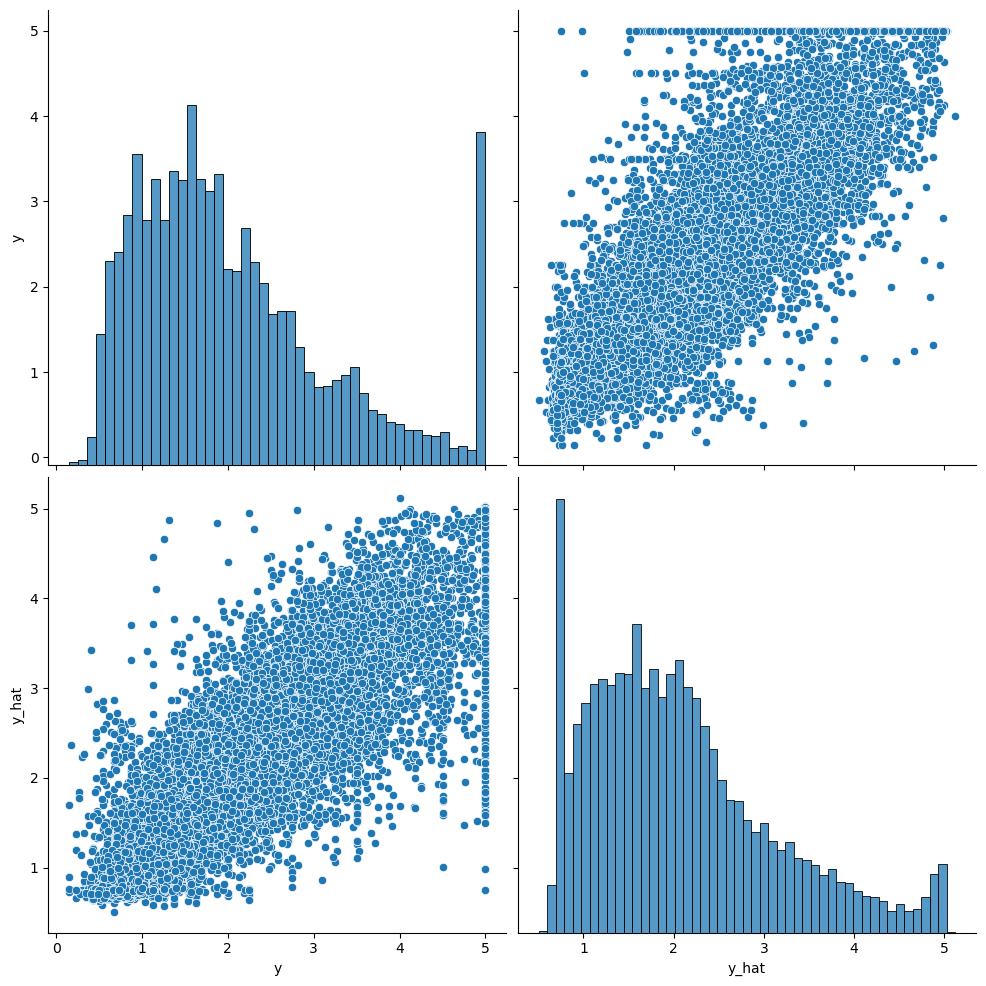

In [13]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach().numpy(),
                 columns = ['y', 'y_hat'])
sns.pairplot(df, height = 5)
plt.show()